In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
from captcha.audio import AudioCaptcha
from captcha.image import ImageCaptcha
import numpy as np
import random
import string
import tensorflow as tf
import tflearn
import pandas as pd

In [3]:
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
from tflearn.data_utils import Preloader,ImagePreloader

In [4]:
GPU_CORE = 0
BATCH_SIZE = 16
dropout = 0.75
rnn_size = 128
bi_layers = 2

In [5]:
width, height, n_len = 130, 70, 6


In [223]:
class CaptchaPreloader(object):
    def __init__(self,width=width,height=height,n_len =4,characters=None):
        if characters == None:
            characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
        self.generator = ImageCaptcha(width=width, height=height)
        self.n_len = n_len
        self.characters = characters
        self.ch2ind = dict(zip(characters,range(1,len(characters) + 1)))
        self.ind2ch = dict(zip(range(1,len(characters) + 1),characters))

    def __getitem__(self, id):
        retimgs,retstrs = [],[]
        for one in id:
            random_str = ''.join([random.choice(self.characters) for j in range(self.n_len)])
            img = self.generator.generate_image(random_str)
            retimgs.append(np.asarray(img)),retstrs.append([self.ch2ind[i] for i in random_str])
        return np.asarray(retimgs),np.asarray(retstrs)

    def __len__(self):
        return 1000000

In [224]:
trainset = CaptchaPreloader()
with tf.device("/gpu:{}".format(GPU_CORE)):
    coord = tf.train.Coordinator()
    trainflow = FeedDictFlow({
            'input_layer':trainset,
        },coord,batch_size=BATCH_SIZE,shuffle=True,continuous=True)
trainflow.start()


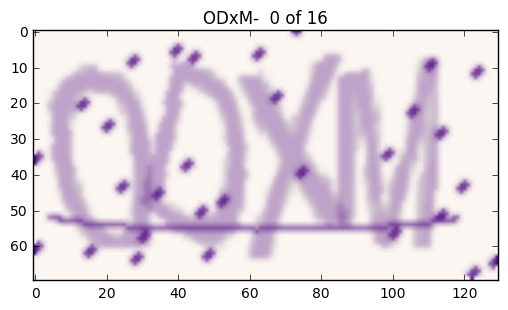

In [225]:
data = trainflow.next()['input_layer']
plt.imshow(data[0][0])
actword = ''.join([trainset.ind2ch[i] for i in data[1][0]])
plt.title(actword + "-  0 of {}".format(len(data[0])))

In [226]:
print(data[0].shape,data[1].shape)

(16, 70, 130, 3) (16, 4)


In [227]:
pd.DataFrame(data[1]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,25,27,19,17,60,29,20,47,11,42,18,24,51,30,4,39
1,14,17,42,44,25,25,2,47,27,18,2,43,20,9,4,32
2,60,50,9,36,44,58,22,35,38,3,35,10,9,22,43,6
3,23,52,30,24,45,41,13,50,14,4,30,54,1,21,17,55


# network

In [94]:
tf.sparse_placeholder(tf.float32, shape=np.array([BATCH_SIZE,4], dtype=np.int64)).get_shape

<bound method SparseTensor.get_shape of <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001FB086F44A8>>

In [96]:
tf.sparse_placeholder(tf.float32, shape=np.array([10, 47], dtype=np.int64)).get_shape()

TensorShape([Dimension(10), Dimension(47)])

In [122]:
TESTIMG_WIDTH = 400

In [285]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

with tf.device("/gpu:{}".format(GPU_CORE)):
    inputs = tf.placeholder(tf.float32, [None, width,height,3 ])
    training = tf.placeholder(tf.bool,name='training_mode')
    targets = tf.sparse_placeholder(tf.int32)#, shape=np.array([BATCH_SIZE,4], dtype=np.int64))
    learning_rate = tf.placeholder(tf.float32)
    
    #global_step = tf.Variable(0, trainable=False)
    global_step = tf.train.get_or_create_global_step()
    
    net = inputs
    for i in range(3):
        for j in range(2):
            net = tf.layers.conv2d(net, 32, (3, 3), activation=None, padding='same', name="conv_{}_{}".format(i + 1,j + 1))
            net = tf.layers.batch_normalization(net, training=training, name="bn_conv_{}_{}".format(i + 1,j + 1))
            net = tf.nn.relu(net,name="relu_conv_{}_{}".format(i + 1,j + 1))
        net = tf.layers.max_pooling2d(net, (2, 2), strides=(2, 2), name="pool_{}".format(i + 1))
    
    net_shape = net.get_shape().as_list()
    net = tf.reshape(net,[-1,net_shape[1],net_shape[2] * net_shape[3]])
    
    net = tf.layers.dense(net,32)
    print(net.get_shape())
    forward_cell = tf.contrib.rnn.DropoutWrapper(
        tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(rnn_size) for i in range(bi_layers)]), input_keep_prob=(1.0 - dropout)
    )
    
    backward_cell = tf.contrib.rnn.DropoutWrapper(
        tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(rnn_size) for i in range(bi_layers)]), input_keep_prob=(1.0 - dropout)
    )
    
    bi_outputs, bi_encoder_state,_ = tf.contrib.rnn.static_bidirectional_rnn(
            forward_cell,backward_cell,tf.unstack(net,net_shape[1],1),dtype=tf.float32)
    
    encoder_outputs = [
        tf.reshape(i,[-1,1,rnn_size * 2]) for i in bi_outputs
    ]
    encoder_outputs = tf.concat(encoder_outputs,1)
    encoder_dropout = tf.nn.dropout(encoder_outputs,keep_prob=dropout)
    net_result = tf.layers.dense(encoder_dropout,len(trainset.characters) + 2,activation=None)
    
    with tf.variable_scope("Loss"):
        ctc_loss = tf.nn.ctc_loss(labels=targets,inputs=net_result,sequence_length=BATCH_SIZE * [net_result.get_shape().as_list()[1]]
                                  ,time_major=False)
        loss = tf.reduce_mean(ctc_loss)
        tf.summary.scalar("Loss",loss)
    
    with tf.variable_scope("Captcha"):
        tf.summary.image('Captcha',inputs,max_outputs=4)
        
   
        
    with tf.variable_scope("LearningRate"):
        tf.summary.scalar("LearningRate",learning_rate)

    # decoder
    decoded, log_prob = tf.nn.ctc_beam_search_decoder(tf.transpose(net_result, (1, 0, 2)), sequence_length=BATCH_SIZE * [net_result.get_shape().as_list()[1]]
                                                  , merge_repeated=True)
    dense_decoded = tf.cast(tf.sparse_tensor_to_dense(decoded[0], default_value=0), tf.int32)
    with tf.variable_scope("EditDistance"):
        dis = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
        tf.summary.scalar("EditDistance",dis)
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=MOMENTUM).minimize(cost, global_step=global_step)
    #optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss,global_step=global_step)
    
    summary_op = tf.summary.merge_all()
    train_summary_writer = tf.summary.FileWriter("./arma_train", sess.graph)
    
    
    
    with tf.variable_scope("Accuracy"):
        accuracy = tf.placeholder(tf.float32)
        accuracy_op = tf.summary.scalar("Accuracy",accuracy)
        alphabetaccuracy = tf.placeholder(tf.float32)
        alphabetaccuracy_op = tf.summary.scalar("AlphabetAccuracy",alphabetaccuracy)
        
    with tf.variable_scope("predictions"):
        prediction_result = tf.placeholder(tf.float32, [None, TESTIMG_WIDTH,TESTIMG_WIDTH,3 ])
        prediction_result_op = tf.summary.image("Predictions",prediction_result)

(?, 16, 32)


In [286]:
net_result.get_shape()

TensorShape([Dimension(None), Dimension(16), Dimension(64)])

In [287]:
sess.run(tf.global_variables_initializer())
tf.train.global_step(sess, global_step)

0

In [288]:
#转化一个序列列表为稀疏矩阵    
def sparse_tuple_from(sequences, dtype=np.int32):
    """
    Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []
    
    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)
 
    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)
    
    
    return indices, values, shape

In [289]:
sparse_tuple_from(data[1])[2],data[0].shape

(array([16,  4], dtype=int64), (16, 70, 130, 3))

In [290]:
N_BATCH = 5000

In [291]:
from utils import ProgressBar

In [292]:
def accuracy_sent(targ,pred):
    targ_shape = targ.shape
    pred_shape = pred.shape
    predmatrix = np.zeros(targ_shape)
    predmatrix[:,:min(targ_shape[1],pred_shape[1])] = pred[:,:min(targ_shape[1],pred_shape[1])]
    
    alpha_acc = np.average(predmatrix == targ)
    actacc = np.average([all(i == j) for i,j in zip(predmatrix,targ)])
    return alpha_acc,actacc

In [296]:
import os
model_name = "init_model"
if not os.path.exists("models/{}".format(model_name)):
    os.mkdir("models/{}".format(model_name))

In [309]:
restore = True
N_EPOCH = 50
DECAY_EPOCH = 100

class ExpVal:
    def __init__(self,exp_a=0.97):
        self.val = None
        self.exp_a = exp_a
    def update(self,newval):
        if self.val == None:
            self.val = newval
        else:
            self.val = self.exp_a * self.val + (1 - self.exp_a) * newval
    def getval(self):
        return round(self.val,2)
    
expdis = ExpVal()
expacc = ExpVal()
expabacc = ExpVal()
exploss = ExpVal()


begining_learning_rate = 1e-2

if restore == False:
    train_epoch = 1
    train_batch = 0
for one_epoch in range(train_epoch,N_EPOCH):
    train_epoch = one_epoch
    pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE,info=" epoch {} batch {}".format(train_epoch,train_batch))
    pb.startjob()
    
    for one_batch in range(N_BATCH):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(BATCH_SIZE)
            pb.auto_display = True
            continue
        else:
            restore = False
        train_batch = one_batch
        
        batch_x,batch_y_ori = trainflow.next()['input_layer']
        batch_x = np.transpose(batch_x,[0,2,1,3])
        batch_y = sparse_tuple_from(batch_y_ori)

        
        
        # learning rate decay strategy
        batch_lr = begining_learning_rate * 10 ** -(one_epoch // DECAY_EPOCH)
        
        step_dis,decoded,_,step_loss,step_summary,step_value = sess.run(
            [dis,dense_decoded,train_op,loss,summary_op,global_step],feed_dict={
                inputs:batch_x,targets:batch_y,learning_rate:batch_lr,training:True
            })
        step_abacc,step_acc = accuracy_sent(targ=batch_y_ori,pred=decoded)
        step_acc *= 100
        step_abacc *= 100
        expdis.update(step_dis)
        expacc.update(step_acc)
        exploss.update(step_loss)
        expabacc.update(step_abacc)
        
        ab_ser,ac_ser,pr_ser = sess.run([alphabetaccuracy_op,accuracy_op,prediction_result_op],feed_dict={
                alphabetaccuracy:step_abacc,accuracy:step_acc,prediction_result:np.zeros([BATCH_SIZE, TESTIMG_WIDTH,TESTIMG_WIDTH,3 ])})
        
        pb.info = "EPOCH {} STEP {} LR {} ACC {} ABACC {} LOSS {} DIS {}".format(
            one_epoch,one_batch,batch_lr,expacc.getval(),expabacc.getval(),exploss.getval(),expdis.getval())
        # add trainging statics to tensorboard
        train_summary_writer.add_summary(step_summary, step_value)
        train_summary_writer.add_summary(ab_ser, step_value)
        train_summary_writer.add_summary(ac_ser, step_value)
        train_summary_writer.add_summary(pr_ser, step_value)
        pb.complete(BATCH_SIZE)

    print()
    saver = tf.train.Saver()
    saver.save(sess,"models/{}/model".format(model_name))

EPOCH 1 STEP 4999 LR 0.01 ACC 0.0 ABACC 0.78 LOSS 17.1 DIS 0.98 100.00 % [==================================================>] 80000/80000 	 used:811s eta:0 s
EPOCH 2 STEP 4999 LR 0.01 ACC 0.0 ABACC 0.59 LOSS 16.99 DIS 0.98 100.00 % [==================================================>] 80000/80000 	 used:1255s eta:0 s
EPOCH 3 STEP 4999 LR 0.01 ACC 0.0 ABACC 0.85 LOSS 17.05 DIS 0.97 100.00 % [==================================================>] 80000/80000 	 used:1258s eta:0 s
EPOCH 4 STEP 4999 LR 0.01 ACC 0.0 ABACC 0.87 LOSS 17.06 DIS 0.97 100.00 % [==================================================>] 80000/80000 	 used:1256s eta:0 s
EPOCH 5 STEP 4999 LR 0.01 ACC 0.0 ABACC 0.67 LOSS 16.99 DIS 0.98 100.00 % [==================================================>] 80000/80000 	 used:1253s eta:0 s
EPOCH 6 STEP 4999 LR 0.01 ACC 0.0 ABACC 0.73 LOSS 17.06 DIS 0.98 100.00 % [==================================================>] 80000/80000 	 used:1251s eta:0 s
EPOCH 7 STEP 4999 LR 0.01 ACC 0.0 AB

KeyboardInterrupt: 